Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

First, load the dataset.

Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.


In [34]:
import pandas as pd
from titlecase import titlecase

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import scipy.stats as stats

from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

#import warnings

In [35]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()

Checking the data of each column

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

Cleaning up the label column and the Dtypes.

In [37]:
# Cleaning up the leadning and following spaces from the column headers
df.columns = df.columns.str.strip()

# Giving some proper caseing to the column names
df.columns = [titlecase(x) if x.isupper() != True else x for x in df.columns]

Lets list out the nulls.

In [40]:
# Displaying the nulls
nans = lambda df: df[df.isnull().any(axis=1)]
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
nans(df)

,Country,Year,Status,Life Expectancy,Adult Mortality,Infant Deaths,Alcohol,Percentage Expenditure,Hepatitis B,Measles,BMI,Under-Five Deaths,Polio,Total Expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 Years,Thinness 5-9 Years,Income Composition of Resources,Schooling
32,Algeria,2015,Developing,75.6,19.0,21,NaN,0.000000,95.0,63,59.5,24,95.0,NaN,95.0,0.1,4132.762920,39871528.0,6.0,5.8,0.743,14.4
37,Côte d'Ivoire,2001,Developing,47.8,467.0,65,3.15,0.000000,1.0,5790,19.9,94,7.0,4.85,66.0,7.0,NaN,NaN,7.9,7.9,NaN,NaN
45,Algeria,2003,Developing,71.7,146.0,20,0.34,25.018523,NaN,15374,47.0,23,87.0,3.60,87.0,0.1,294.335560,3243514.0,6.3,6.1,0.663,11.5
46,Algeria,2002,Developing,71.6,145.0,20,0.36,148.511984,NaN,5862,46.1,23,86.0,3.73,86.0,0.1,1774.336730,3199546.0,6.3,6.2,0.653,11.1
47,Algeria,2001,Developing,71.4,145.0,20,0.23,147.986071,NaN,2686,45.3,24,89.0,3.84,89.0,0.1,1732.857979,31592153.0,6.4,6.3,0.644,10.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,Zambia,2003,Developing,46.4,64.0,39,2.33,65.789974,NaN,881,17.6,62,85.0,8.18,83.0,18.2,429.158343,11421984.0,7.3,7.2,0.443,10.2
2919,Zambia,2002,Developing,45.5,69.0,41,2.44,54.043480,NaN,25036,17.3,66,85.0,6.93,84.0,18.4,377.135244,111249.0,7.4,7.3,0.433,10.0
2920,Zambia,2001,Developing,44.6,611.0,43,2.61,46.830275,NaN,16997,17.1,70,86.0,6.56,85.0,18.6,378.273624,1824125.0,7.4,7.4,0.424,9.8
2921,Zambia,2000,Developing,43.8,614.0,44,2.62,45.616880,NaN,30930,16.8,72,85.0,7.16,85.0,18.7,341.955625,1531221.0,7.5,7.5,0.418,9.6


Here we can see some of the data is represented by zeros.  Going to properly represent them with a NaN value, while retain all the original data points.

This will also change the Dtype to float64 for consistency.

In [42]:
#Replace zeros with NaN, can assume zeros
df2 = df.replace(0, np.nan)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life Expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   Infant Deaths                    2090 non-null   float64
 6   Alcohol                          2744 non-null   float64
 7   Percentage Expenditure           2327 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          1955 non-null   float64
 10  BMI                              2904 non-null   float64
 11  Under-Five Deaths                2153 non-null   float64
 12  Polio               

Taking a look at the percentage of null values per category.

In [26]:
# Percentage of nulls now in the dataframe
df2.isnull().sum() * 100/df2.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life Expectancy                     0.340368
Adult Mortality                     0.340368
Infant Deaths                      28.863172
Alcohol                             6.603131
Percentage Expenditure             20.796460
Hepatitis B                        18.822328
Measles                            33.458135
BMI                                 1.157250
Under-Five Deaths                  26.718856
Polio                               0.646698
Total Expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
Thinness  1-19 Years                1.157250
Thinness 5-9 Years                  1.157250
Income Composition of Resources    10.108918
Schooling                           6.501021
dtype: flo

There is an abnormal amount of data that has not been reported for a few of these categories.  Specificaly Infant Deaths, Percentage Expenditure, Hepatitis B, Measles, Under-Five Deaths, GDP, and Population.

Visualizing the Null values.

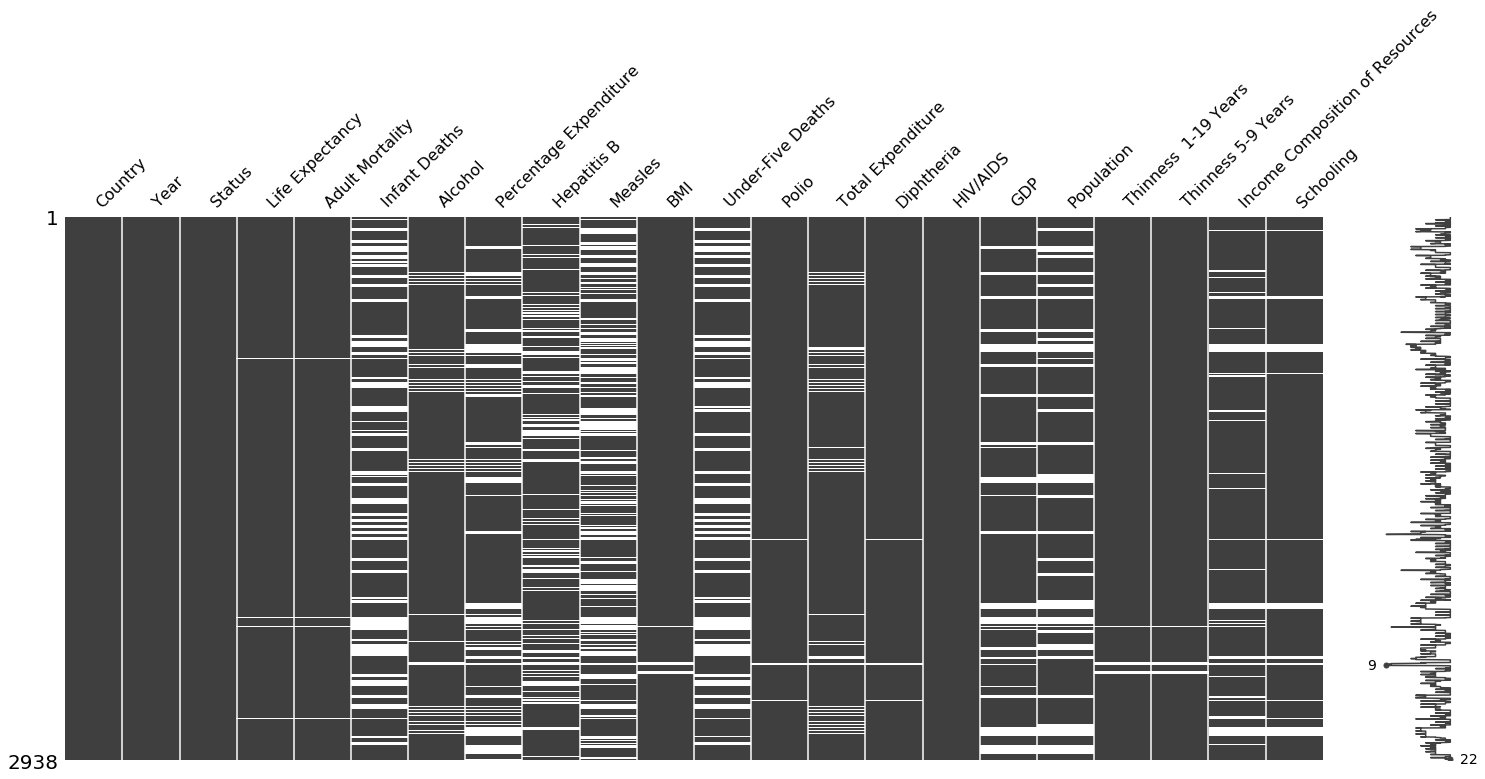

In [43]:
# Visualling the nulls
msno.matrix(df2)

This gives a good visual of what the percentage numbers have already told us.

Filling in the null values with interpolate then check the percentage of null values in the dataset afterward.

In [45]:
# Look at the columns to see if they are null
data_cols = ['Life Expectancy', 'Adult Mortality', 'Infant Deaths', 'Alcohol', 'Percentage Expenditure',
            'Hepatitis B', 'Measles', 'BMI', 'Under-Five Deaths', 'Polio', 'Total Expenditure',
            'Diphtheria', 'GDP', 'Population', 'Thinness  1-19 Years',
            'Thinness 5-9 Years', 'Income Composition of Resources', 
            'Schooling']
#df2 = df.copy()

# Fill in the null values of the columns
for col in data_cols:
    #df2[col].fillna(df2[col].mean(), inplace=True)
    df2.loc[:, col] = df2.loc[:, col].interpolate()
    
df2.isnull().sum() * 100/df2.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life Expectancy                    0.0
Adult Mortality                    0.0
Infant Deaths                      0.0
Alcohol                            0.0
Percentage Expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
Under-Five Deaths                  0.0
Polio                              0.0
Total Expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
Thinness  1-19 Years               0.0
Thinness 5-9 Years                 0.0
Income Composition of Resources    0.0
Schooling                          0.0
dtype: float64

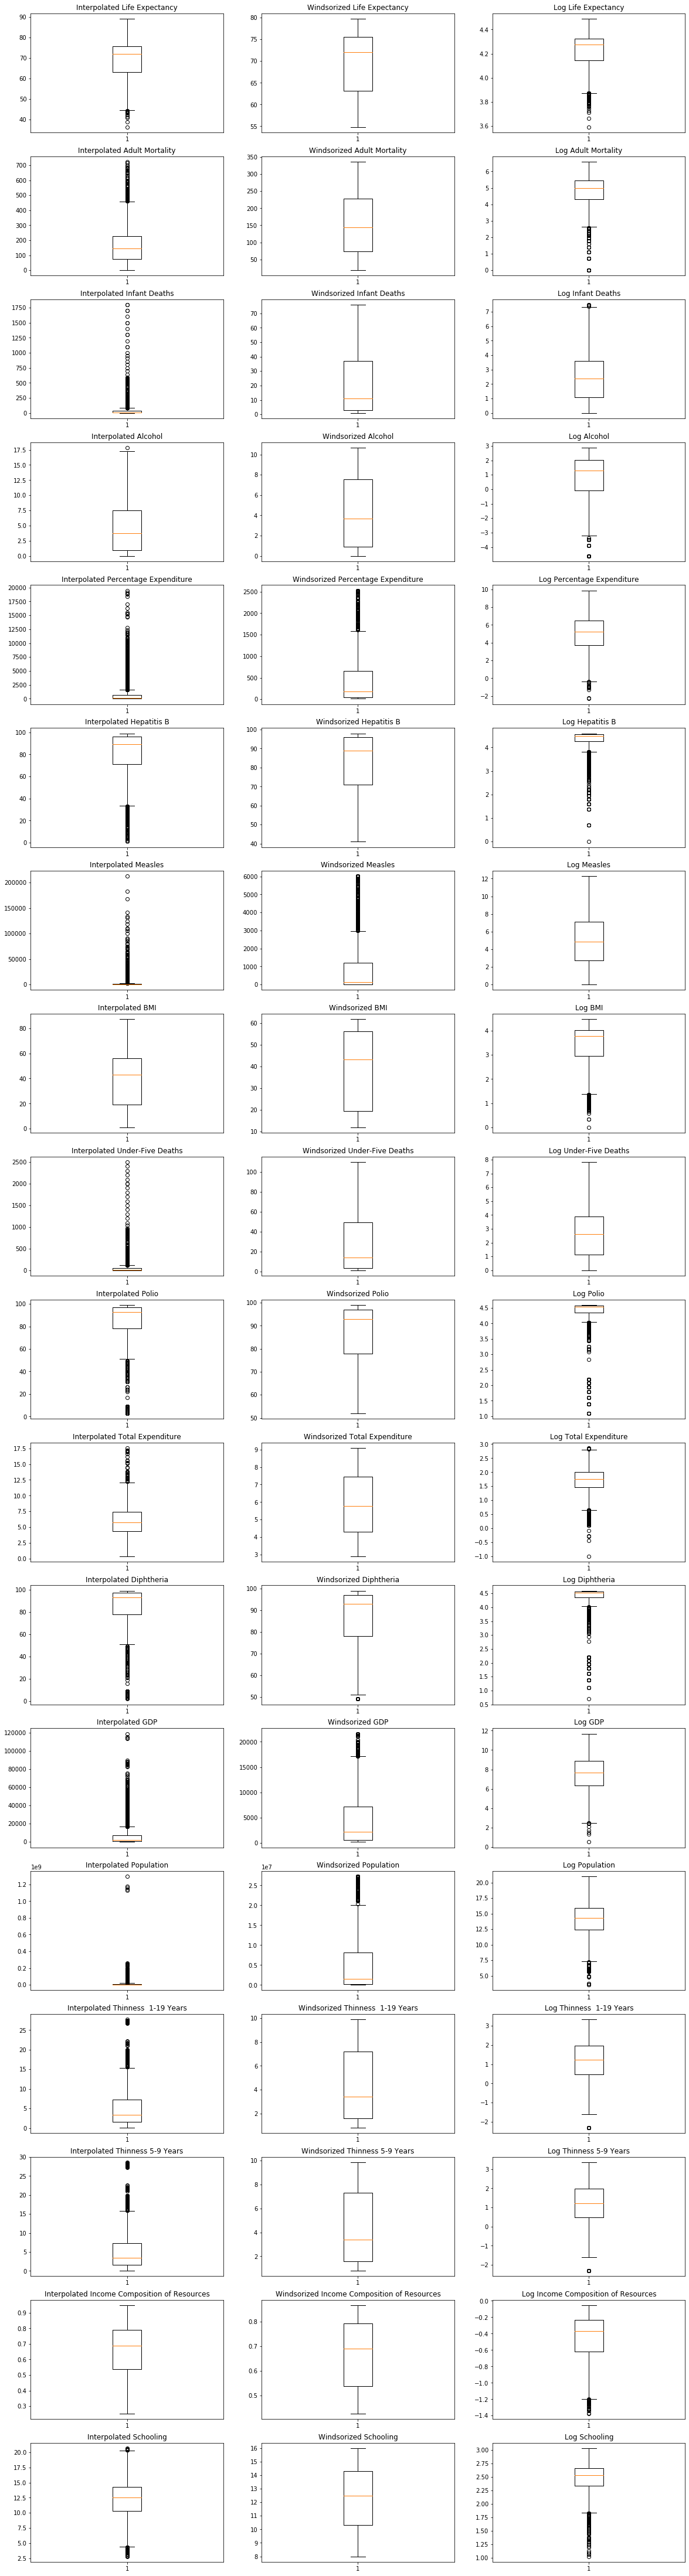

In [52]:
# Box plots to view the outliers and Winsorize
plt.figure(figsize=(20,80))
i = 1
z = len(data_cols)
for col in data_cols:
    plt.subplot(z, 3, i)
    plt.boxplot(df2[col])
    plt.title('Interpolated ' + col)
    i += 1
    
    plt.subplot(z, 3, i)
    plt.boxplot(winsorize(df2[col], (0.10, 0.10)))
    plt.title('Windsorized ' + col)
    i += 1
    
    plt.subplot(z, 3, i)
    plt.boxplot(np.log(df2[col]))
    plt.title('Log ' + col)
    i += 1
    
plt.show()

Outliers after being winsorized.

In [53]:
# Computing the Outliers from winsorization
for col in data_cols:
    q75, q25 = np.percentile(winsorize(df2[col], (0, 0.10)), [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print('{} Score Threshold: {}  Outliers: {}'.format(col, threshold, len(
            (np.where((winsorize(df2[col], (0.10, 0.10)) > max_val) | (
                winsorize(df2[col], (0.10, 0.10)) < min_val))[0]))))

Life Expectancy Score Threshold: 1.0  Outliers: 0
Life Expectancy Score Threshold: 1.5  Outliers: 0
Life Expectancy Score Threshold: 2.0  Outliers: 0
Life Expectancy Score Threshold: 2.5  Outliers: 0
Life Expectancy Score Threshold: 3.0  Outliers: 0
Life Expectancy Score Threshold: 3.5  Outliers: 0
Life Expectancy Score Threshold: 4.0  Outliers: 0
Life Expectancy Score Threshold: 4.5  Outliers: 0
Adult Mortality Score Threshold: 1.0  Outliers: 0
Adult Mortality Score Threshold: 1.5  Outliers: 0
Adult Mortality Score Threshold: 2.0  Outliers: 0
Adult Mortality Score Threshold: 2.5  Outliers: 0
Adult Mortality Score Threshold: 3.0  Outliers: 0
Adult Mortality Score Threshold: 3.5  Outliers: 0
Adult Mortality Score Threshold: 4.0  Outliers: 0
Adult Mortality Score Threshold: 4.5  Outliers: 0
Infant Deaths Score Threshold: 1.0  Outliers: 318
Infant Deaths Score Threshold: 1.5  Outliers: 0
Infant Deaths Score Threshold: 2.0  Outliers: 0
Infant Deaths Score Threshold: 2.5  Outliers: 0
Infant

There are a large amount of outliers in the Percent Expenditure, Under-Five Deaths, Diphtheria, and Population.  There is inaccuracy in the way this data is imported or been inputed.  Lets see how the log transformation will effect these outliers.

In [92]:
# Computing the outliers from computing log
for col in data_cols:
    q75, q25 = np.percentile(np.log(df2[col]), [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print('{} Score Threshold: {}  Outliers: {}'.format(col, threshold, 
                        len((np.where((np.log(df2[col]) > max_val) | (np.log(df2[col]) < min_val))[0]))
                                                         ))

Life Expectancy Score Threshold: 1.0  Outliers: 211
Life Expectancy Score Threshold: 1.5  Outliers: 82
Life Expectancy Score Threshold: 2.0  Outliers: 9
Life Expectancy Score Threshold: 2.5  Outliers: 2
Life Expectancy Score Threshold: 3.0  Outliers: 1
Life Expectancy Score Threshold: 3.5  Outliers: 0
Life Expectancy Score Threshold: 4.0  Outliers: 0
Life Expectancy Score Threshold: 4.5  Outliers: 0
Adult Mortality Score Threshold: 1.0  Outliers: 368
Adult Mortality Score Threshold: 1.5  Outliers: 166
Adult Mortality Score Threshold: 2.0  Outliers: 61
Adult Mortality Score Threshold: 2.5  Outliers: 30
Adult Mortality Score Threshold: 3.0  Outliers: 20
Adult Mortality Score Threshold: 3.5  Outliers: 12
Adult Mortality Score Threshold: 4.0  Outliers: 0
Adult Mortality Score Threshold: 4.5  Outliers: 0
Infant Deaths Score Threshold: 1.0  Outliers: 45
Infant Deaths Score Threshold: 1.5  Outliers: 5
Infant Deaths Score Threshold: 2.0  Outliers: 0
Infant Deaths Score Threshold: 2.5  Outliers

In the log tranformation Adult Mortality, Alcohol, Hepatitis B, Polio, Total Expenditure, Diphtheria, and Schooling have a large amount of outliers.
There are a large amount of outliers in the Percent Expenditure, Under-Five Deaths, Diphtheria, and Population.  There is inaccuracy in the way this data is imported or been inputed.  Lets see how the log transformation will effect these outliers.

Use log on Adult Mortality, Alcohol, Hepatitis B, Polio, Total Expenditure, Diphtheria, and Schooling
Use winsorize on Percent Expenditure, Under-Five Deaths, Diphtheria, and Population
Diptheria not good on both

In [ ]:
pd.set_option('max_rows', None)
df2[['Country', 'Year', 'Total Expenditure', 'GDP']]

### Univariate Analysis

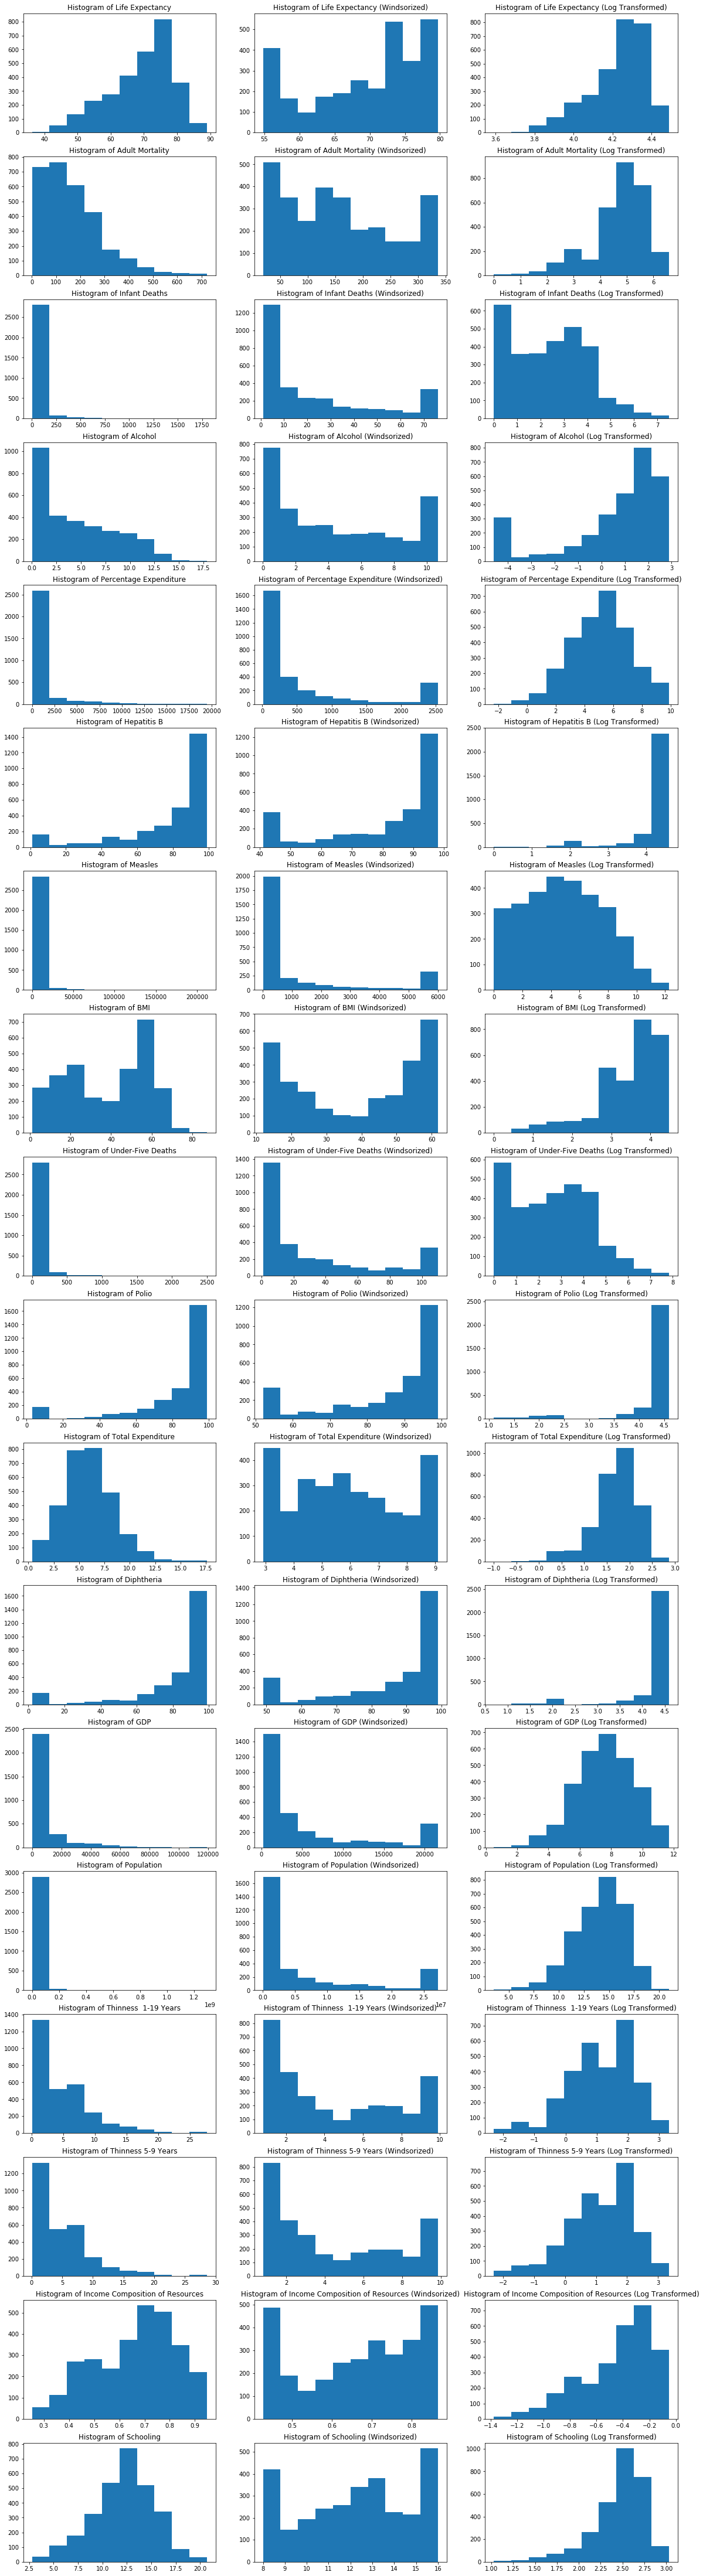

In [97]:
plt.figure(figsize=(20,80))
i = 1
z = len(data_cols)
for col in data_cols:
    plt.subplot(z, 3, i)
    plt.hist(df2[col])
    plt.title('Histogram of ' + col)
    i += 1
    
    plt.subplot(z, 3, i)
    plt.hist(winsorize(df2[col], (0.10, 0.10)))
    plt.title('Histogram of ' + col + ' (Windsorized)')
    i += 1
    
    plt.subplot(z, 3, i)
    plt.hist(np.log(df2[col]))
    plt.title('Histogram of ' + col + ' (Log Transformed)')
    i += 1
    
plt.show()

There does not seem to be any apparent correlation between the other variables and life expectancy.

### Bivariate Analysis

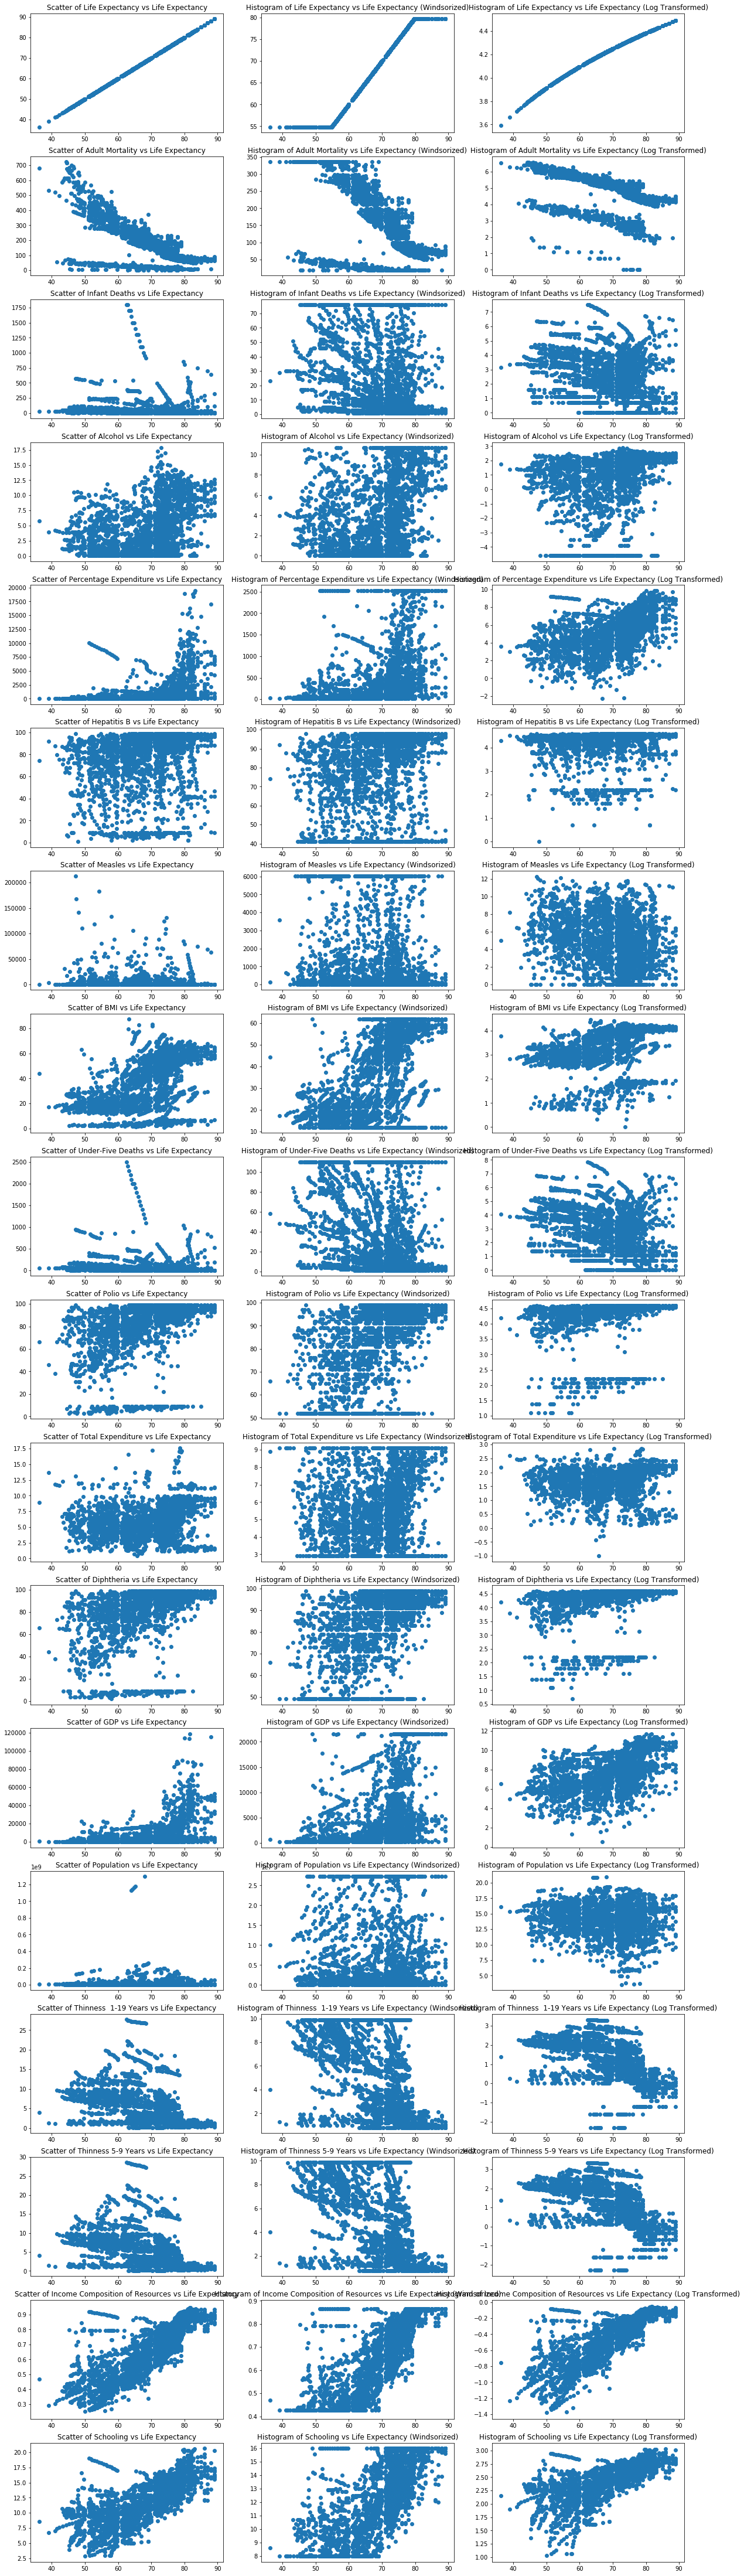

In [101]:
plt.figure(figsize=(20,80))
i = 1
z = len(data_cols)
for col in data_cols:
    plt.subplot(z, 3, i)
    plt.scatter(df2['Life Expectancy'], df2[col])
    plt.title('Scatter of ' + col + ' vs Life Expectancy')
    i += 1
    
    plt.subplot(z, 3, i)
    plt.scatter(df2['Life Expectancy'], winsorize(df2[col], (0.10, 0.10)))
    plt.title('Histogram of ' + col + ' vs Life Expectancy (Windsorized)')
    i += 1
    
    plt.subplot(z, 3, i)
    plt.scatter(df2['Life Expectancy'], np.log(df2[col]))
    plt.title('Histogram of ' + col + ' vs Life Expectancy (Log Transformed)')
    i += 1
    
plt.show()

The histograms are indicating that Schooling, Income Composition of Resources, and GDP have a positive impact on the Live Expectancy.

Lets see if a Correlation coefficient can support those claims.

In [103]:
df2.corr()

,Year,Life Expectancy,Adult Mortality,Infant Deaths,Alcohol,Percentage Expenditure,Hepatitis B,Measles,BMI,Under-Five Deaths,Polio,Total Expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 Years,Thinness 5-9 Years,Income Composition of Resources,Schooling
Year,1.000000,0.168309,-0.079264,-0.024184,-0.064487,0.060675,0.145777,-0.076378,0.100417,-0.026100,0.095580,0.079345,0.135174,-0.139741,0.089699,0.019915,-0.038570,-0.040661,0.123344,0.163674
Life Expectancy,0.168309,1.000000,-0.695730,-0.104481,0.400068,0.347757,0.247419,-0.120748,0.556433,-0.130979,0.459865,0.210843,0.474084,-0.555929,0.435854,-0.007126,-0.476809,-0.472485,0.826685,0.729442
Adult Mortality,-0.079264,-0.695730,1.000000,0.014392,-0.194070,-0.223577,-0.162578,0.006710,-0.383224,0.029875,-0.272553,-0.116293,-0.273311,0.523245,-0.283332,-0.025440,0.307734,0.314769,-0.540605,-0.440496
Infant Deaths,-0.024184,-0.104481,0.014392,1.000000,-0.071221,0.026123,-0.153565,0.516246,-0.153325,0.994683,-0.118815,-0.082108,-0.122363,-0.007795,-0.028430,0.501154,0.378797,0.381740,-0.080039,-0.080519
Alcohol,-0.064487,0.400068,-0.194070,-0.071221,1.000000,0.318848,0.092366,-0.045903,0.319618,-0.073736,0.222830,0.289631,0.218683,-0.048190,0.342275,-0.029223,-0.420123,-0.408260,0.526804,0.528300
Percentage Expenditure,0.060675,0.347757,-0.223577,0.026123,0.318848,1.000000,-0.063310,0.061590,0.197184,0.023318,0.124109,0.141316,0.100309,-0.109921,0.842511,-0.027068,-0.232547,-0.236576,0.470220,0.441505
Hepatitis B,0.145777,0.247419,-0.162578,-0.153565,0.092366,-0.063310,1.000000,-0.103341,0.172639,-0.161500,0.446056,0.088999,0.532925,-0.117155,0.031839,-0.080645,-0.141744,-0.150593,0.226445,0.212250
Measles,-0.076378,-0.120748,0.006710,0.516246,-0.045903,0.061590,-0.103341,1.000000,-0.127396,0.513845,-0.109832,-0.071608,-0.112766,0.016050,-0.037021,0.207058,0.170383,0.166095,-0.043967,-0.055798
BMI,0.100417,0.556433,-0.383224,-0.153325,0.319618,0.197184,0.172639,-0.127396,1.000000,-0.163445,0.282080,0.233848,0.280483,-0.243181,0.271717,-0.060964,-0.533952,-0.540459,0.570036,0.530295
Under-Five Deaths,-0.026100,-0.130979,0.029875,0.994683,-0.073736,0.023318,-0.161500,0.513845,-0.163445,1.000000,-0.136642,-0.084008,-0.142847,0.004913,-0.034002,0.487594,0.381622,0.383394,-0.096807,-0.096837


There is a good correlation of Life Expectancy with Schooling and Income Composition of Resources.  G